# 5. Análisis de tópicos con LDA (Latent Dirichlet Allocation)

## 5.1 Motivación

El __análisis de tópicos__ permite descubrir, a partir de los propios textos, el conjunto de tópicos que estos abordan. Se trata de un análisis automatizado, que podría ser difícil de llevar a cabo manualmente, debido a la cantidad de textos.

Uno de los algoritmos más comunes para analizar tópicos es el algoritmo _Latent Dirichlet Allocation (LDA)_ (Artículo "Latent Dirichlet Allocation" : https://drive.google.com/file/d/1BobImO3192hifZPLXowd14gryVAUzBPW/view)

__¿Qué hace LDA?__

Dado un número de tópicos definido por el analista, el modelo permite asociar una distribución de tópicos $\theta_d$ a cada texto $d$ y al mismo tiempo, la distribución de palabras $\beta_t$ en cada tópico $t$.

<img src="img/f1.jpg"/>

<img src="img/f2.jpg"/>

## 5.2 ¿Cómo hacer un análisis de tópicos en Python?

En este tutorial, tomaremos un dataset de noticias de prensa en español del mes de febrero 2021 y utilizaremos LDA para descubrir cuáles son los tópicos de las noticias.

### 5.2.1 Cargar el dataset de noticias

In [1]:
import pandas

# leer el archivo CSV
archivo = "./data/catrillanca.csv"
corpus = pandas.read_csv(archivo)

In [2]:
corpus.head(5)

,Unnamed: 0,id_news,country,media_outlet,url,title,text,date
0,0,243393.0,chile,horas24,https://www.24horas.cl/nacional/instituto-naci...,Instituto Nacional de Derechos Humanos amplía ...,El Instituto Nacional de Derechos Humanos (IND...,2019-06-22
1,1,5163425.0,chile,ahoranoticiasmega,https://www.meganoticias.cl/nacional/268476-pa...,Padre de Catrillanca solicita presencia de Bac...,Hasta el Palacio de la Moneda llegó Marcelo Ca...,2019-07-17
2,2,13829736.0,chile,emol,https://www.emol.com/noticias/Nacional/2019/03...,"Adolescente que acompañaba a Catrillanca: ""Hab...",SANTIAGO.- A casi cuatro meses de la muerte de...,2019-03-10
3,3,5439896.0,chile,ahoranoticiasmega,https://www.meganoticias.cl/nacional/245535-ca...,Cartas enviadas a familia de Camilo Catrillanc...,"Hace unos días Marcelo Catrillanca, padre de C...",2018-12-30
4,4,5442943.0,chile,ahoranoticiasmega,https://www.meganoticias.cl/nacional/245302-ca...,Caso Catrillanca: Comuneros mapuche se toman l...,"Durante la mañana de este jueves, un grupo de ...",2018-12-27


- Son 2.931 noticias en total.

In [3]:
len(corpus)

2931

- Creamos una lista de noticias a partir del corpus

In [4]:
noticias = corpus.text.values.tolist()

In [5]:
noticias[501]

'El 14 de noviembre de 2018, en la comuna de Ercilla en la Región de La Araucanía, un grupo de integrantes del Comando Jungla del GOPE de Carabineros asesinó al comunero mapuche de 24 años, Camilo Catrillanca. El crimen se realizó en el contexto de un operativo por un supuesto delito de robo que minutos antes habìa tenido lugar, identificando erradamente los policías a Catrillanca como uno de los participantes en el atraco, disparándole entonces mientras este se encontraba sobre el tractor en el que trabajaba. El joven iba entonces acompañado por su amigo de 15 años de iniciales M.A.P.C., quien fue agredido y torturado por los uniformados. Desde entonces ha pasado un año y el caso se encuentra en manos de la Justicia, la que este próximo 30 de noviembre llevará a cabo la audiencia de juicio oral en contra de los carabineros acusados por el crimen de Camilo. Federico Aguirre, jefe regional de La Araucanía del Instituto Nacional de Derechos Humanos (INDH), querellante en este caso, decla

### 5.2.2  Instalación de librerias

- Instalamos en nuestra máquina la libreria "pyLDAvis" que permite visualizar los resultados del análisis de tópicos 

Note bene: los comandos "pip install .." solo se hacen una vez para descargar las librerias en su computador.

In [6]:
#!pip install pyLDAvis

- Utilizaremos spacy para procesar textos en español (no es útil instalar la libreria con "pip instal..." ya que ya lo hicimos en notebook anterior)

In [7]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load("es_core_news_sm")
matcher = Matcher(nlp.vocab)

- Utilizaremos Gensim (para el análisis de tópicos) y pyLDAvis (para visualizar los tópicos)

In [8]:
# !pip install gensim
# !pip install pyLDAvis

In [9]:
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\darko\Miniconda3\envs\myenv\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


### 5.2.3 Preprocesamiento de las noticias

Procesaremos todas las noticias para representarlas como una lista de:
- sustantivos (NOUN)
- y conceptos claves (NOUN-de-NOUN) y (NOUN-ADJ)
- entidades (PER) y (ORG)

- Agregamos patrones para buscar conceptos claves

In [10]:
pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

- Definemos una función para preprocesar una noticia y transformarla en una lista de "palabras" relevantes.

In [11]:
def text_to_list(noticia):
    list_of_words = []
    
    try:
        doc = nlp(noticia)

        for token in doc:
            if (token.pos_=="NOUN"):
                list_of_words.append(token.text)

        for ent in doc.ents:
            if (ent.label_ == "PER" and " " in ent.text):
                list_of_words.append(ent.text)

        matches = matcher(doc)

        for match_id, start, end in matches:
            span = doc[start:end]  # The matched span
            list_of_words.append(span.text)
    
    except Exception as e: 
        print(noticia)
        print(e)
    
    return list_of_words

In [12]:
noticias[0]

'El Instituto Nacional de Derechos Humanos (INDH) solicitó al Juzgado de Garantía de Collipulli ampliar la querella por la muerte de Camilo Catrillanca, fallecido el 14 de noviembre de 2018 durante un operativo policial en la región de la Araucanía. De acuerdo lo que consigna el INDH en su sitio web, ya han presentado cuatro acciones judiciales en el caso. Se trata de una querella por el homicidio de Catrillanca, una por obstrucción a la investigación, una por el homicidio frustrado del adolescente de 15 años que acompañaba a Camilo Catrillanca la jornada de su muerte, además de las querellas por torturas que habría sufrido este último tras ser detenido. La organización también plantea que ha prestado apoyo y acompañamiento a la familia de Camilo Catrillanca en las distintas aristas tras la muerte del joven dirigente mapuche. Además, indican que han participado de procesos como la observación ocular de la autopsia del cuerpo de Catrillanca, la reconstitución de la escena de los eventos

In [13]:
text_to_list(noticias[0])

['querella',
 'muerte',
 'noviembre',
 'operativo',
 'región',
 'acuerdo',
 'INDH',
 'sitio',
 'acciones',
 'caso',
 'querella',
 'homicidio',
 'obstrucción',
 'investigación',
 'homicidio',
 'adolescente',
 'años',
 'jornada',
 'muerte',
 'querellas',
 'torturas',
 'organización',
 'apoyo',
 'acompañamiento',
 'familia',
 'aristas',
 'muerte',
 'joven',
 'dirigente',
 'procesos',
 'observación',
 'autopsia',
 'cuerpo',
 'reconstitución',
 'escena',
 'eventos',
 'toma',
 'declaración',
 'uniformados',
 'operativo',
 'proceso',
 'investigación',
 'caso',
 'reabierto',
 'plazo',
 'semanas',
 'petición',
 'defensa',
 'peritajes',
 'Juzgado de Garantía de Collipulli',
 'Camilo Catrillanca',
 'Camilo Catrillanca',
 'Camilo Catrillanca',
 'operativo policial',
 'sitio web',
 'acciones judiciales',
 'homicidio frustrado',
 'dirigente mapuche',
 'observación ocular',
 'toma de declaración',
 'declaración de uniformados',
 'uniformados involucrados',
 'proceso de investigación',
 'investigación

- Transformamos todas las noticias de nuestro corpus "noticias" aplicando la función "text_to_list". De cierta manera, simplificará el texto guardando solamente las palabras y conceptos importantes.

In [14]:
noticias_procesadas = []

for index, noticia in enumerate(noticias):
    print(index)
    noticia_procesada = text_to_list(noticia)
    noticias_procesadas.append(noticia_procesada)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

- Veamos cómo se transformó una cierta noticia. La variable "N" representa el rango de la noticia en nuestro corpus.

In [15]:
N=5

In [16]:
print(noticias[N])

Marcelo Catrillanca, padre del comunero mapuche asesinado, se refirió al nuevo video correspondiente a una segunda cámara que estaba en poder de uno de los excarabineros que participó en el operativo del pasado 14 de noviembre donde murió Camilo Catrillanca. "Nosotros siempre dijimos la verdad, que ese video existía. Siguen apareciendo evidencias", sostuvo Catrillanca desde el Congreso. En ese sentido, manifestó que "estaban todos informados, por lo que ellos querían ocultar la verdad". En particular, apuntó a la responsabilidad del general director de Carabineros, Hermes Soto, señalando que él mintió. "Tiene que ser imputado y condenado porque ocultó la verdad que los funcionarios que estaban a su cargo, lo hicieron", sostuvo el padre de Catrillanca. "Creo que el general director de Carabineros debería dar un paso al costado, así como el ministro del Interior, Andrés Chadwick", sostuvo. Agregó, que "nosotros queremos saber quién mató a mi hijo". Marcelo Catrillanca presentó durante es

- Se simplificó en:

In [17]:
print(noticias_procesadas[5])

['padre', 'comunero', 'video', 'cámara', 'poder', 'excarabineros', 'operativo', 'noviembre', 'verdad', 'video', 'evidencias', 'sentido', 'verdad', 'particular', 'responsabilidad', 'general', 'director', 'verdad', 'funcionarios', 'cargo', 'padre', 'director', 'paso', 'costado', 'ministro', 'hijo', 'jornada', 'carta', 'esclarecimiento', 'Marcelo Catrillanca', 'Camilo Catrillanca', 'Hermes Soto', 'Marcelo Catrillanca', 'comunero mapuche', 'video correspondiente', 'esclarecimiento histórico']


### 5.2.4 Preparar los datos de entrada de LDA

los datos de entrada de LDA son: 
- un diccionario (variable 'id2word')
- nuestro dataset preprocesado ('noticias_procesadas')

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(noticias_procesadas)
id2word

- Se asigna una ID a cada palabra (o concepto) del vocabulario. Por ejemplo con el ID=25 corresponde a la palabra:

In [19]:
id2word[179]

'abuelo'

In [20]:
texts = noticias_procesadas

- Ahora una noticia se vuelve imposible de leer para un humano. Miremos por ejemplo la noticia N.

In [21]:
dataset = [id2word.doc2bow(noticia_procesada) for noticia_procesada in noticias_procesadas]

# View
print(dataset[:N])

[[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 3), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1)], [(0, 2), (27, 2), (28, 2), (29, 1), (33, 1), (55, 1), (56, 2), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 2), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1)], [(0, 1), (7, 5), (11, 1), (12, 1), (26, 1), (28, 4), (29, 1), (65, 1), (69, 2), (70, 2), (73, 3),

### 4. Entrenamiento del modelo de tópico con LDA

- Entrenaremos un primer modelo de tópicos buscando un modelo con 5 tópicos. 

In [22]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

- Guardaremos el modelo en el disco duro

In [23]:
lda_model.save('./output/lda_model_catrillanca_5')

FileNotFoundError: [Errno 2] No such file or directory: './output/lda_model_catrillanca_5.state'

### 5. Visualizar los tópicos encontrados

- Se puede imprimir los tópicos con sus principales palabras principales...

In [ ]:
from pprint import pprint

pprint(lda_model.print_topics(num_words=100))

[(0,
  '0.012*"mujeres" + 0.011*"libertad" + 0.007*"hija" + 0.006*"años" + '
  '0.006*"derechos" + 0.006*"edad" + 0.006*"detención" + 0.006*"arquitectura" '
  '+ 0.005*"identidad" + 0.005*"revuelta" + 0.004*"uso" + 0.004*"salud" + '
  '0.004*"controles" + 0.004*"pobladores" + 0.004*"compañeras" + '
  '0.003*"artículo" + 0.003*"adolescentes" + 0.003*"niños" + 0.003*"casa" + '
  '0.003*"niñas" + 0.003*"cura" + 0.003*"aislamiento" + 0.003*"cabros" + '
  '0.003*"años de edad" + 0.003*"INDH" + 0.003*"maquillaje" + 0.003*"amparo" + '
  '0.003*"tortura" + 0.003*"indulto" + 0.003*"tratos" + 0.003*"mamá" + '
  '0.002*"misas" + 0.002*"Mariano Puga" + 0.002*"preso político" + '
  '0.002*"aplicación" + 0.002*"ideología" + 0.002*"prisioneros" + '
  '0.002*"artistas" + 0.002*"religión" + 0.002*"síntesis" + 0.002*"sacerdotes" '
  '+ 0.002*"carnet" + 0.002*"humanos" + 0.002*"fallo" + 0.002*"recurso" + '
  '0.002*"materia de derechos" + 0.002*"zapatismo" + 0.002*"crímenes" + '
  '0.002*"canción" + 0.00

- ... o se puede visualizar mejor con la libreria pyLDAvis

Nota bene: el número que identifica los topicos puede cambiar... 

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, dataset, id2word)
vis

/home/alex/miniconda3/envs/myenv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/home/alex/miniconda3/envs/myenv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/alex/miniconda3/envs/myenv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/alex/miniconda3/envs/myenv/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/alex/minico

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.280364  0.011458       1        1  60.217950
4      0.155696 -0.212086       2        1  21.542594
2      0.007093  0.329096       3        1  13.000625
0     -0.205247 -0.094573       4        1   2.944766
1     -0.237906 -0.033894       5        1   2.294065, topic_info=             Term         Freq        Total Category  logprob  loglift
3183            }   850.000000   850.000000  Default  30.0000  30.0000
321        fiscal  1485.000000  1485.000000  Default  29.0000  29.0000
201      gobierno  1844.000000  1844.000000  Default  28.0000  28.0000
2285            $   551.000000   551.000000  Default  27.0000  27.0000
11           años  2516.000000  2516.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
3162          oct    62.775436    63.719326   Topic5  -4.8819   3.7599
3140  font-weight    40.333227    40.725208   Topic5  -5.3243   3.7652
948         color    83.731610   122.503942   Topic5  -4.5938   3.3943
3732     segundos    42.473377    49.414345   Topic5  -5.2726   3.6235
1538       imagen    42.764700   177.586025   Topic5  -5.2657   2.3511

[304 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
2081      5  0.999684                   #
2285      5  0.999300                   $
4077      5  0.987293                   '
4080      5  0.990018           //obtener
0         1  0.727246  Camilo Catrillanca
...     ...       ...                 ...
257       2  0.056420                zona
3183      5  0.999050                   }
3184      5  0.999902                 } #
4428      3  0.995458              ámbito
6335      4  0.998224                   ’

[379 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 3, 1, 2])

### 6. Calcular las metricas de Perplejidad (_Model Perplexity_) y Coherencia (_Coherence Score_)

La perplejidad del modelo y la coherencia del tema proporcionan metricas estadisticas para evaluar que tan revante es un modelo para describir el dataset.

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(dataset))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=noticias_procesadas, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.636156178299375

Coherence Score:  0.4467225977935854


### 7. ¿Cómo encontrar cuál es el mejor número de tópicos para describir el dataset?

- Queremos encontrar el modelo que optimiza la métrica de coherencia (o minimiza la métrica de perplejidad). Probaremos con distintos valores de número de tópicos.

In [ ]:
### NO CAMBIAR ESTA CELDA###

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        
        model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

- Entrenaremos modelos desde 2 tópicos hasta 15 tópicos con un salto de 2 --> 2, 4, 6, 8, 10, 12, 14

Nota bene: Se puede demorar varios minutos (o incluso varias horas según el tamaño del dataset)

In [ ]:
start=2
limit=15
step=2

print(type(id2word))
print(type(dataset))
print(type(noticias_procesadas))

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=dataset, texts=noticias_procesadas, start=start, limit=limit, step=step)

2
4
6
8
10
12
14


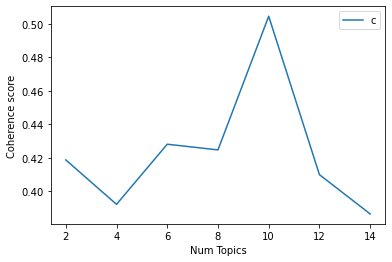

In [ ]:

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

- ¿Cuál modelo conservar? Miraremos la métrica de coherencia...

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4188
Num Topics = 4  has Coherence Value of 0.3922
Num Topics = 6  has Coherence Value of 0.4281
Num Topics = 8  has Coherence Value of 0.4247
Num Topics = 10  has Coherence Value of 0.5046
Num Topics = 12  has Coherence Value of 0.41
Num Topics = 14  has Coherence Value of 0.3865


In [ ]:
# Select the model and print the topics
optimal_model = model_list[4]

- Guardaremos el mejor modelo en un archivo para poder reutilizarlo despues sin volver a entrenar...

In [ ]:
archivo='./output/optimal_model_catrillanca_10'

In [ ]:
optimal_model.save(archivo)

- En cualquier momento, se puede volver a cargar el model desde el archivo, sin volver a entrenar el modelo...

In [ ]:
from gensim.models import LdaModel

optimal_model = LdaModel.load(archivo, mmap='r')

- Visualizemos el modelo de tópicos

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, dataset, id2word)
vis

/home/alex/miniconda3/envs/myenv/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/home/alex/miniconda3/envs/myenv/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/alex/miniconda3/envs/myenv/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/alex/miniconda3/envs/myenv/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/alex/miniconda3/envs/myenv/lib/python3.8/site-packages/j

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.337288 -0.075107       1        1  48.354976
6     -0.249301 -0.260621       2        1  23.907795
7     -0.221479  0.354062       3        1  14.706586
5     -0.201789  0.020235       4        1   9.922984
4      0.101183  0.009727       5        1   2.538888
8      0.188809 -0.010547       6        1   0.257258
2      0.184188 -0.009933       7        1   0.165145
0      0.180802 -0.009602       8        1   0.113000
1      0.178562 -0.009244       9        1   0.028852
9      0.176313 -0.008970      10        1   0.004517, topic_info=                        Term         Freq        Total Category  logprob  \
82                  ministro  3173.000000  3173.000000  Default   30.000   
3183                       }  1178.000000  1178.000000  Default   29.000   
507                oposición  1392.000000  1392.000000  Default   28.000   
2285                       $   763.000000   763.000000  Default   27.000   
201                 gobierno  2095.000000  2095.000000  Default   26.000   
...                      ...          ...          ...      ...      ...   
25    investigación judicial     0.000415     5.041689  Topic10  -10.578   
26                   jornada     0.000415   351.339369  Topic10  -10.578   
27                     joven     0.000415   607.454840  Topic10  -10.578   
28                    muerte     0.000415  1152.182629  Topic10  -10.578   
29                 noviembre     0.000415  1061.818874  Topic10  -10.578   

      loglift  
82    30.0000  
3183  29.0000  
507   28.0000  
2285  27.0000  
201   26.0000  
...       ...  
25     0.6006  
26    -3.6434  
27    -4.1910  
28    -4.8311  
29    -4.7494  

[517 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2081      5  0.997993          #
2285      5  0.999514          $
4077      5  1.000109          '
4080      5  0.987858  //obtener
765       1  1.000066       2018
...     ...       ...        ...
257       1  0.997226       zona
257       3  0.003463       zona
3183      5  0.999965          }
3184      5  0.999373        } #
3911      4  1.001097    órdenes

[415 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 8, 6, 5, 9, 3, 1, 2, 10])

### 8. ¿Cuál es el tópico principal de cada documento?

- Podemos analizar cuál es el tópico principal de cada documento

In [ ]:
def format_topics_documents(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_documents(ldamodel=optimal_model, corpus=dataset, texts=noticias)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/tmp/ipykernel_6660/4135286971.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/tmp/ipykernel_6660/4135286971.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6,0.6303,"fiscal, años, investigación, caso, abogado, re...",El Instituto Nacional de Derechos Humanos (IND...
1,1,6,0.3631,"fiscal, años, investigación, caso, abogado, re...",Hasta el Palacio de la Moneda llegó Marcelo Ca...
2,2,6,0.5003,"fiscal, años, investigación, caso, abogado, re...",SANTIAGO.- A casi cuatro meses de la muerte de...
3,3,3,0.6260,"parte, personas, años, caso, general, año, car...","Hace unos días Marcelo Catrillanca, padre de C..."
4,4,3,0.7843,"parte, personas, años, caso, general, año, car...","Durante la mañana de este jueves, un grupo de ..."
5,5,3,0.5262,"parte, personas, años, caso, general, año, car...","Marcelo Catrillanca, padre del comunero mapuch..."
6,6,6,0.4926,"fiscal, años, investigación, caso, abogado, re...","Durante la tarde de este lunes, fue detenido M..."
7,7,6,0.7338,"fiscal, años, investigación, caso, abogado, re...","Este lunes fue detenido Marcelo Catrillanca, p..."
8,8,3,0.7452,"parte, personas, años, caso, general, año, car...",El padre de Camilo Catrillanca realizó un llam...
9,9,3,0.4920,"parte, personas, años, caso, general, año, car...",Un comunero mapuche murió tras ser herido a ba...


- La variable "df_dominant_topic" contiene una columna "Dominant_topic" que indica el tópico principal en cada documento y cuál su porcentaje (variable "Topic_Perc_contrib")

- Añadiremos la columna "media_outlet" para saber de qué medio viene cada noticia

In [ ]:
media_outlet = dataset.filter(['media_outlet'], axis=1)
df_dominant_topic=df_dominant_topic.join(media_outlet)
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,media_outlet
0,0,6,0.6303,"fiscal, años, investigación, caso, abogado, re...",El Instituto Nacional de Derechos Humanos (IND...,horas24
1,1,6,0.3631,"fiscal, años, investigación, caso, abogado, re...",Hasta el Palacio de la Moneda llegó Marcelo Ca...,ahoranoticiasmega
2,2,6,0.5003,"fiscal, años, investigación, caso, abogado, re...",SANTIAGO.- A casi cuatro meses de la muerte de...,emol
3,3,3,0.6260,"parte, personas, años, caso, general, año, car...","Hace unos días Marcelo Catrillanca, padre de C...",ahoranoticiasmega
4,4,3,0.7843,"parte, personas, años, caso, general, año, car...","Durante la mañana de este jueves, un grupo de ...",ahoranoticiasmega
...,...,...,...,...,...,...
2926,2926,3,0.5520,"parte, personas, años, caso, general, año, car...","Acusados por incendios, porte y lanzamiento de...",elciudadano
2927,2927,3,0.4956,"parte, personas, años, caso, general, año, car...",Mauricio Hernández Norambuena (62) pasó 17 año...,elciudadano
2928,2928,3,0.4956,"parte, personas, años, caso, general, año, car...",Mauricio Hernández Norambuena (62) pasó 17 año...,elciudadano
2929,2929,3,0.6114,"parte, personas, años, caso, general, año, car...",ARTE Delight lab: Artistas y activistas lumíni...,latercera


- Podemos contar cuántos documentos son por tópicos principales:

In [ ]:
from pandasql import sqldf 

In [ ]:
result = sqldf("SELECT Dominant_Topic, count(*) as nb_noticias FROM df_dominant_topic GROUP BY Dominant_Topic ORDER BY count(*) DESC")
result

,Dominant_Topic,nb_noticias
0,3,1871
1,6,735
2,5,159
3,7,127
4,4,39


- ¿Cuál es la noticia más representativa de cada tópcio?

- Tópico 1

In [ ]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=1.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 1")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,media_outlet


- Tópico 2

In [ ]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=2.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 1")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,media_outlet


- Tópico 5

In [ ]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=5.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 5")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,media_outlet
0,2093,5,0.6692,"ministro, oposición, gabinete, acusación, diputado, gobierno, jefe, ministros, responsabilidad, parlamentarios","Este miércoles los partidos de oposición anunciaron que crearán una mesa jurídica para estudiar una eventual acusación contra el ministro del Interior, Andrés Chadwick, luego de que se conocieran nuevos antecedentes en el marco del caso Catrillanca. El diputado Manuel Monsalve explicó que todas las bancadas de oposición están disponibles para analizar la presentación de este recurso contra el jefe de gabinete y en este sentido anunció la creación de una mesa técnica formada por abogados constitucionalistas ""del más alto nivel"" que redacte un libelo que entregue fundamentos jurídicos para la acusación constitucional. Esta iniciativa fue respaldada por todas las bancadas de la oposición, desde el Frente Amplio hasta la Democracia Cristiana. Monsalve agregó en este caso la ""convicción política"" debe ser equilibrada con los ""fundamentos jurídicos"". En esta línea, el diputado Matías Walker se refirió a los cuestionamientos que sufrió la DC luego de que ayer desestimara impulsar el recur...",latercera
1,114,5,0.6517,"ministro, oposición, gabinete, acusación, diputado, gobierno, jefe, ministros, responsabilidad, parlamentarios","Ante los nuevos cuestionamientos surgidos en torno a la presunta responsabilidad política del ministro del Interior, Andrés Chadwick, en el caso Catrillanca, la presidenta de la UDI, Jacqueline Van Rysselberghe, respaldó la versión entregadas por el secretario de Estado y, de pasó, acusó ""aprovechamiento político"" de la oposición. ""El ministro nunca dijo que Catrillanca iba armado"", sostiene. En concreto, se le critica a Chadwick lo declarado en Fiscalía por el exgeneral de Carabineros Mauro Victtoriano, quien apuntó que informó al titular de Interior desde el comienzo respecto a que Camilo Catrillanca y el menor que lo acompañaba se encontraban desarmados. El ministro, por su parte, acusó ""interferencias"" en las comunicaciones al momento de recibir el mensaje. Consultada por las críticas procedentes de la oposición -quienes evalúan incluso una acusación constitucional- la timonel de la UDI señaló a Radio Duna que el caso Catrillanca y, en este caso, el rol de Chadwick ""los une com...",ahoranoticiasmega
2,273,5,0.6508,"ministro, oposición, gabinete, acusación, diputado, gobierno, jefe, ministros, responsabilidad, parlamentarios","SANTIAGO.- Previo al inicio de la interpelación al titular del Interior, Andrés Chadwick, por parte de la diputada Emilia Nuyado (PS), la Cámara aprobó este martes la creación de una comisión investigadora por la muerte del comunero mapuche Camilo Catrillanca. La formación de la instancia fue visada esta tarde por 97 votos a favor, ocho en contra y 29 abstenciones . Ésta tiene como objetivo indagar el actuar del Ministerio del Interior, la Policía de Investigaciones y Carabineros, en los hechos que concluyeron con el fallecimiento de Catrillanca. Noticia relacionada Comisión investigadora por muerte de Catrillanca se cae por falta de quórum: Apuntan a ausencia de diputados de oposición El pasado 28 de noviembre, la votación de la comisión había sufrido un traspié, debido a que no se había alcanzado el quórum necesario para su aprobación, lográndose solo 59 de los 62 votos requeridos. Lo anterior dado que no estaban todos los parlamentarios de oposición presentes en la Sala...",emol
3,214,5,0.6471,"ministro, oposición, gabinete, acusación, diputado, gobierno, jefe, ministros, responsabilidad, parlamentarios","El padre de Camilo Catrillanca exigió la renuncia inmediata del ministro del Interior, Andrés Chadwick y el subsecretario, Rodrigo Ubilla, tras el informe de la comisión investigadora de la Cámara de Diputados, que estableció responsabilidades políticas en la muerte del comunero. En conversación con Radio Bío Bío de Temuco, Marcelo Catrillanca, padre del comunero map

- Tópico 6

In [ ]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=6.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 3")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,media_outlet
0,2626,6,0.9548,"fiscal, años, investigación, caso, abogado, relación, funcionarios, prisión, fiscalía, delito","El Tribunal Oral de Angol fijó para el 26 de noviembre, a las 09.00, el inicio del juicio oral contra los responsables del homicidio de Camilo Catrillanca, comunero mapuche que murió el 14 de noviembre de 2018, tras recibir un disparo en la cabeza por parte de un carabinero, en la comuna de Ercilla, Región de La Araucanía. El persecutor de la Unidad de DDHH de la Fiscalía Regional de La Araucanía, Roberto Garrido, señaló que ""con esto se inicia entonces la última etapa en esta investigación, que consiste en el juzgamiento de los hechos que han sido materia de la formalización. Durante el juicio oral la Fiscalía pretende acompañar todos los medios de prueba que ha reunido durante esta investigación para demostrar los hechos en que se fundamenta la acusación de la fiscalía"". El Ministerio Públicó ofreció a más de 70 testigos, 30 peritos y una serie de pruebas documentales y evidencia material para acreditar las acusaciones contra los imputados. ""Toda la prueba ofrecida porla fiscalía...",latercera
1,1756,6,0.9511,"fiscal, años, investigación, caso, abogado, relación, funcionarios, prisión, fiscalía, delito","A las 18.00 horas de este lunes, la Unidad de Derechos Humanos de la Fiscalía Regional de La Araucanía presentó acusación en el marco del caso Catrillanca, haciendo uso del plazo de 10 días con el que contaba el organismo persecutor para deducir acusación desde la fecha de cierre. La acusación, ingresada al Juzgado de Garantía de Collipulli a través de la Oficina Judicial Virtual considera penas para los carabineros involucrados en la muerte del comunero mapuche en noviembre de 2018. Las mayores penas fueron solicitadas para el exsargento del GOPE, Carlos Alarcón,para quien se pidieron 10 años y un día de presidio por el homicidio simple consumado de Camilo Catrillanca y 5 años y un día de presidio por el homicidio frustrado del menor que lo acompañaba. En el caso de Raúl Ávila Morales, se solicita la pena de 4 años de presidio menor en su grado máximo por el delito de apremios ilegítimos en perjuicio de M.A.P.C; de 3 años y 1 día de reclusión menor en su grado máximo más multa de ...",horas24
2,1300,6,0.9354,"fiscal, años, investigación, caso, abogado, relación, funcionarios, prisión, fiscalía, delito","Homicidio simple, apremios ilegítimos cometidos por funcionarios públicos y obstrucción a la investigación, son parte de los delitos por los que el Ministerio Público solicitó hasta 15 años de presidio en contra de los exCarabineros por la muerte de Camilo Catrillanca. Las máximas pena fueron solicitadas en contra del exsargento Carlos Alarcón Molina, sindicado como el autor del disparo que terminó con la vida del comunero el pasado 14 de noviembre de 2018. Para él, la Fiscalía pidió una pena de 10 años y un día de presidio mayor en su grado medio por el delito de homicidio simple consumado y de 5 años y un día de presidio mayor en su grado mínimo por el delito de homicidio simple frustrado, en contra del menor de edad que se encontraba junto a Catrillanca el día de su muerte. Para el exsargento del denominado ""Comando Jungla"", Raúl Ávila, quien en primera instancia aseguró haber destruido una tarjeta de memoria con una tijera para “proteger imágenes personales”, la fiscalía solic...",ahoranoticiasmega


- tópico 7

In [ ]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=7.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 1")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,media_outlet
0,2756,7,0.6727,"gobierno, proyecto, crisis, presidente, país, año, pueblo, tema, pueblos, derecha","Propuestas que van desde 20 a 24 escaños reservados para que los pueblos originarios participen en le proceso constituyente, es lo que se ha planteado durante los dos días de audiencia que ha realizado la Comisión de Constitución del Senado para conocer las opiniones de expertos y también de los representantes de los pueblos originarios que existen en el país. Casi una veintena de organizaciones y comunidades han expuesto ante la Comisión que ha sesionado en dobles jornadas diarias con el objeto de recabar las opiniones sobre la materia. Es así como han surgido temas comunes como por ejemplo, la necesidad de respetar la paridad de género en la representación de los pueblos originarios y también que todos los pueblos tengan representación, entre otros aspectos. Durante la primera jornada de análisis, el Servel señaló que hay que resolver los detalles de la implementación de esta medida a objeto de que el servicio pueda tomar todas las prevenciones necesarias para que puedan aplica...",elciudadano


In [ ]:
noticias[1943]

'Salir a comer junto a tu perro nunca fue tan divertido como en Ushisuke, una cadena de restaurantes que se ubica en Tokyo y Yakohama, en Japón, donde los comensales pueden ir acompañados de sus caninos, sin ningún problema. En el particular restaurante no solo cocinan deliciosas carne para ti, sino también que también tienen disponible un menú exclusivo para tu perro. El lugar no ha escapado de la fiebre viral y usuarios aprovechan para compartir en las redes sociales imágenes y videos cuando visitan el lugar junto a sus peludos. View this post on InstagramA post shared by わたあめ (@wata201312) A post shared by わたあめ (@wata201312) MIRA TAMBIÉN:\xa0Paleontólogo chileno bautiza como "Camilo Catrillanca" a desaparecida especie de pez espada Las mascotas pueden sentarse a la mesa y ordenar, además el alimento para las criaturas parece ser ligeramente diferente de lo que comen: View this post on InstagramA post shared by もち&あずき (@mocci_azuki) A post shared by もち&あずき (@mocci_azuki) View this 

- tópico 8

In [ ]:
?


IPython -- An enhanced Interactive Python

IPython offers a fully compatible replacement for the standard Python
interpreter, with convenient shell features, special commands, command
history mechanism and output results caching.

At your system command line, type 'ipython -h' to see the command line
options available. This document only describes interactive features.

GETTING HELP
------------

Within IPython you have various way to access help:

  ?         -> Introduction and overview of IPython's features (this screen).
  object?   -> Details about 'object'.
  object??  -> More detailed, verbose information about 'object'.
  %quickref -> Quick reference of all IPython specific syntax and magics.
  help      -> Access Python's own help system.

If you are in terminal IPython you can quit this screen by pressing `q`.


MAIN FEATURES
-------------

* Access to the standard Python help with object docstrings and the Python
  manuals. Simply type 'help' (no quotes) to invoke it.

* Ma

__¿Conclusiones?__

- El tópico de "violaciones/democracia/manifestaciones" nunca es el tópico central de la noticia que hablan de Catrillanca. Es un tópico al segundo plano.

- ...

__¿Cómo nombrar los tópicos?__

Del más frecuente al menos frecuente...

6 --> Consecuencias del caso Catrillanca para el gobierno y sus ministros

8 --> Consecuencias judiciales del caso Catrillanca

1 --> Relato del caso Catrillanca

2 --> Noticias que integran un medio con ruido HTML (video, redes sociales)

5 --> Crisis de confianza instituciones Carabiñeros y Fuerzas Armadas



¿Qué medios hablan de crisis de confianza?

In [ ]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT media_outlet,dominant_topic, count(*) FROM df_dominant_topic GROUP BY media_outlet,dominant_topic ORDER BY media_outlet, count(*) DESC")
result

,media_outlet,Dominant_Topic,count(*)
0,ahoranoticiasmega,3,290
1,ahoranoticiasmega,6,138
2,ahoranoticiasmega,7,23
3,ahoranoticiasmega,5,18
4,biobiochile,3,102
5,biobiochile,6,90
6,biobiochile,5,13
7,biobiochile,7,7
8,elciudadano,3,202
9,elciudadano,6,109


In [ ]:
data = {'t0':[],'t1':[],'t2':[],'t3':[],'t4':[],'t5':[],'t6':[],'t7':[],'t8':[],'t9':[]}

df_by_media = pd.DataFrame(data)  
  
df_by_media

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9


In [ ]:
 for i, row_list in enumerate(optimal_model[dataset]):
    
    t0=0
    t1=0
    t2=0
    t3=0
    t4=0
    t5=0
    t6=0
    t7=0
    t8=0
    t9=0
    
    for topic in row_list[0]:
        key=topic[0]
        value=topic[1]
        
        if key == 0:
            t0 = value
        if key == 1:
            t1 = value
        if key == 2:
            t2 = value
        if key == 3:
            t3 = value
        if key == 4:
            t4 = value
        if key == 5:
            t5 = value
        if key == 6:
            t6 = value
        if key == 7:
            t7 = value
        if key == 8:
            t8 = value
        if key == 9:
            t9 = value
            
    new_row = {'t0':t0,'t1':t1,'t2':t2,'t3':t3,'t4':t4,'t5':t5,'t6':t6,'t7':t7,'t8':t8,'t9':t9}
    df_by_media = df_by_media.append(new_row, ignore_index=True)

/tmp/ipykernel_6660/3513166613.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_by_media = df_by_media.append(new_row, ignore_index=True)
/tmp/ipykernel_6660/3513166613.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_by_media = df_by_media.append(new_row, ignore_index=True)
/tmp/ipykernel_6660/3513166613.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_by_media = df_by_media.append(new_row, ignore_index=True)
/tmp/ipykernel_6660/3513166613.py:40: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_by_media = df_by_media.append(new_row, ignore_index=True)
/tmp/ipykernel_6660/3513166613.py:40: FutureWarning: The frame.a

In [ ]:
df_by_media=df_by_media.join(media_outlet)

In [ ]:
df_by_media

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,media_outlet
0,0.00000,0.0,0.00000,0.341919,0.000000,0.000000,0.630310,0.014834,0.0,0.0,horas24
1,0.00000,0.0,0.01868,0.341477,0.000000,0.171631,0.363122,0.101640,0.0,0.0,ahoranoticiasmega
2,0.08128,0.0,0.00000,0.399991,0.000000,0.000000,0.500301,0.011725,0.0,0.0,emol
3,0.00000,0.0,0.00000,0.625928,0.000000,0.010367,0.331855,0.028762,0.0,0.0,ahoranoticiasmega
4,0.00000,0.0,0.00000,0.784285,0.000000,0.051415,0.143688,0.016565,0.0,0.0,ahoranoticiasmega
...,...,...,...,...,...,...,...,...,...,...,...
2926,0.00000,0.0,0.00000,0.552015,0.000000,0.037267,0.274836,0.124600,0.0,0.0,elciudadano
2927,0.00000,0.0,0.00000,0.495632,0.000000,0.012789,0.131635,0.352368,0.0,0.0,elciudadano
2928,0.00000,0.0,0.00000,0.495634,0.000000,0.012789,0.131634,0.352367,0.0,0.0,elciudadano
2929,0.00000,0.0,0.00000,0.611362,0.014809,0.017099,0.088012,0.268568,0.0,0.0,latercera


In [ ]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT media_outlet,avg(t0),avg(t1),avg(t2),avg(t3),avg(t4),avg(t5),avg(t6),avg(t7),avg(t8),avg(t9) FROM df_by_media GROUP BY media_outlet ORDER BY media_outlet ASC")
result

,media_outlet,avg(t0),avg(t1),avg(t2),avg(t3),avg(t4),avg(t5),avg(t6),avg(t7),avg(t8),avg(t9)
0,ahoranoticiasmega,0.001216,0.000162,0.001174,0.495547,0.009401,0.081316,0.309157,0.095458,0.001406,0.0
1,biobiochile,0.000631,0.000648,0.004084,0.457256,0.005512,0.074970,0.371781,0.078171,0.002337,0.0
2,elciudadano,0.002091,0.000000,0.000790,0.478004,0.004556,0.065796,0.329295,0.111558,0.001726,0.0
3,elmostrador,0.000259,0.000168,0.000423,0.443207,0.002302,0.058650,0.369688,0.117180,0.001940,0.0
4,emol,0.000372,0.000067,0.000859,0.500556,0.008759,0.114178,0.224011,0.144065,0.001704,0.0
5,horas24,0.001196,0.000076,0.001490,0.449110,0.073324,0.098463,0.269460,0.100492,0.001332,0.0
6,latercera,0.000573,0.000123,0.000592,0.499300,0.004123,0.128069,0.223441,0.136901,0.001422,0.0


In [ ]:
import seaborn as sns
%matplotlib inline

<AxesSubplot:>

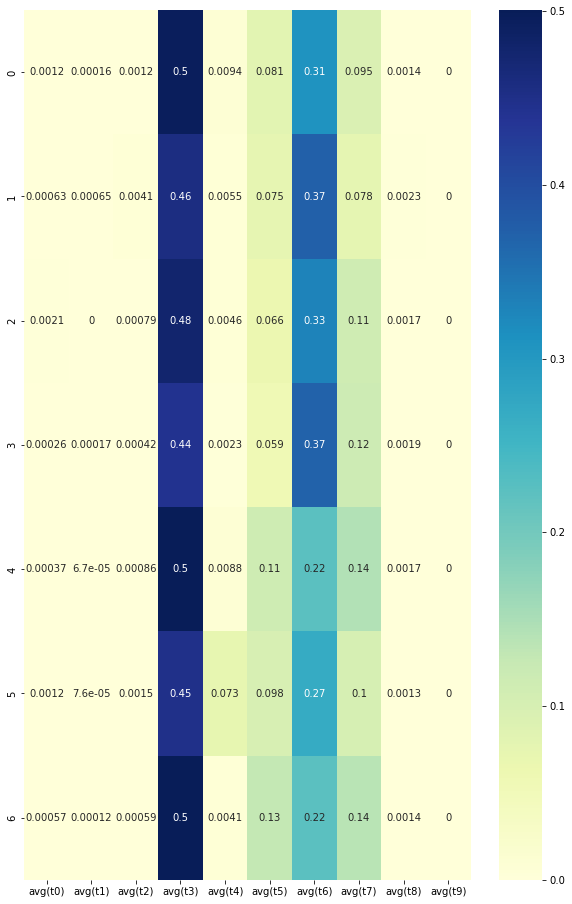

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 16))

result=result.drop(['media_outlet'], axis=1)
sns.heatmap(result, annot=True, cmap="YlGnBu")